<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/hyperbolic_convex_hull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# plots a geodesic segment through complex numbers a and b, with color c
def plot_geodesic(a,b,c):
    if abs(a.real - b.real) <= 2/900:
        plt.plot([a.real,b.real],[a.imag,b.imag],color=c)
        return
    o = ((a.real**2 + a.imag**2 - b.real**2 - b.imag**2) / (2*(a.real - b.real)), 0)
    x = np.linspace(min(a.real,b.real), max(a.real,b.real), 1000)
    arc = lambda x: np.sqrt(np.linalg.norm(np.array([a.real,a.imag]) - np.array(o))**2 - (x - o[0])**2) + o[1]
    y = [arc(xi) for xi in x]
    plt.plot(x,y,color=c)

In [3]:
def plot_point(p,c):
    ax = plt.gca()
    ax.add_artist(plt.Circle((p.real, p.imag), 0.04, facecolor=c, alpha=0.7))

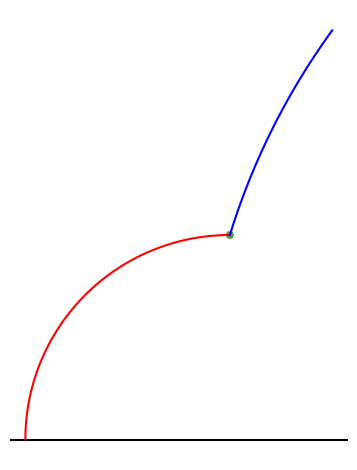

In [4]:
a = 1 + 0j
b = 3 + 2j
c = 4 + 4j

fig, ax = plt.subplots()
ax.axhline(0, color='black')

plot_point(b,'green')
plot_geodesic(a,b,'red')
plot_geodesic(b,c,'blue')

ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()